# Oscillation Investigation into NREL Design Loads

OpenFAST simulations are carried out as part of an ongoing research project into design loads. The well-known 5MW NREL reference turbine is used. For wind speeds above the cut-out threshold, very low frequencies for the flapwise moment were observed. This Notebook aims at investigating these. 

In [2]:
# Python includes

import matplotlib.pyplot as plt
import pandas as pd

%matplotlib notebook

from os import path
from glob import glob

In [8]:
# exemplary data file lives under ../data/

# convert the header line (copied from the input data file) into a list of names
header_names_raw='Time        Wind1VelX   Wind1VelY   Wind1VelZ   RootMFlp1   RootMFlp2   RootMFlp3   RootMEdg1   RootMEdg2   RootMEdg3   LSSTipVxa   B1Pitch     B2Pitch     B3Pitch     RtSpeed     Wave1Elev   -ReactMXss  -ReactMYss'
header_names = [name for name in header_names_raw.split(' ') if len(name) != 0]

# convert the unit line (copied from the input data file) into a lift of units
header_units_raw='(s)         (m/s)       (m/s)       (m/s)       (kN-m)      (kN-m)      (kN-m)      (kN-m)      (kN-m)      (kN-m)      (rpm)       (deg)       (deg)       (deg)       (rpm)       (m)         (Nm)        (Nm)      '
header_units = [unit for unit in header_units_raw.split(' ') if len(unit) != 0]

# join both lists together to generate a list of names with units
header = [' '.join([name, unit]) for name, unit in zip(header_names, header_units)]

# definition of file paths (should work under windows as well)
file_name_glob = '*.out'
data_dir = path.join('..', 'data')

# dict to store data in
timeseries = dict()

In [14]:
for data_file in glob(path.join(data_dir, file_name_glob)):
    if not path.isfile(data_file):
        print('skipping {}'.format(data_file))
        continue
    
    # extract wind speed 
    wind_speed = data_file.split('_')[1].split('.')[0]
    
    # read in time series data file
    timeseries[wind_speed] = pd.read_csv(data_file, 
                                         delimiter='\t', 
                                         skip_blank_lines=True, 
                                         skiprows=9, 
                                         names=header)
    # set time column as index
    timeseries[wind_speed].set_index('Time (s)', inplace=True)
    
    # calculate rotor speed in Hz and insert into dataframe
    timeseries[wind_speed].insert(loc=len(timeseries[wind_speed].columns), 
                                  column='RtSpeed (Hz)', 
                                  value=timeseries[wind_speed]['RtSpeed (rpm)'].apply(lambda x: x/60.0))


## Rotor speeds for all available time series

<IPython.core.display.Javascript object>


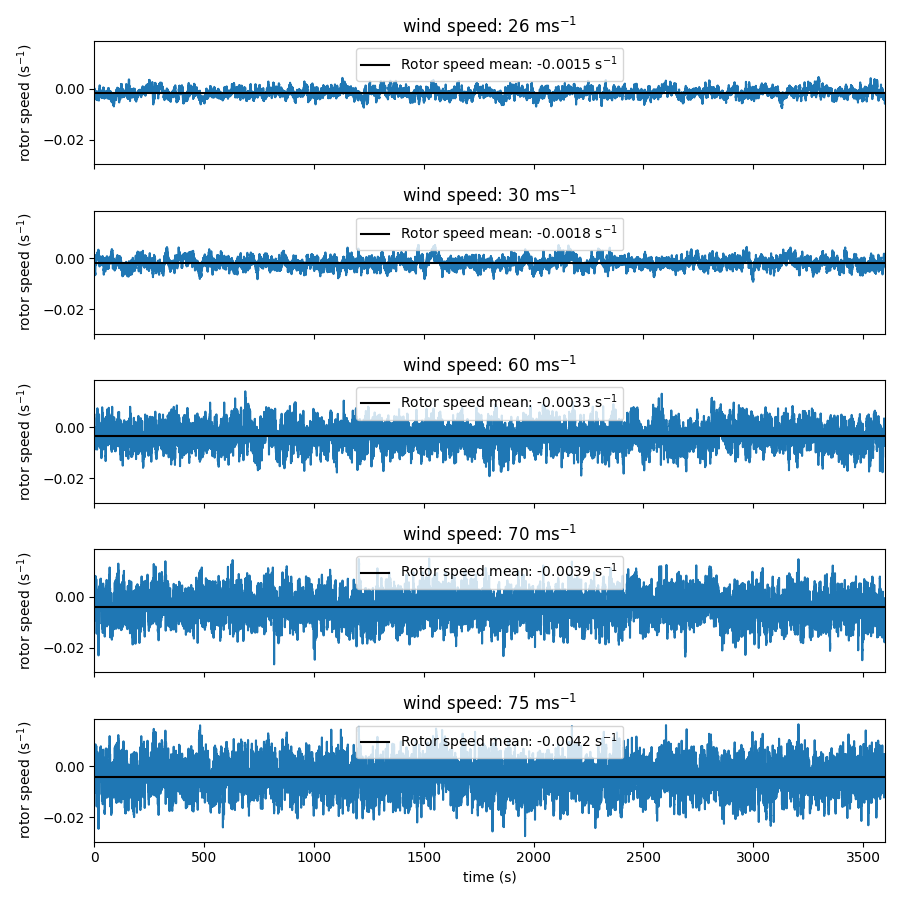

In [39]:
fig, ax = plt.subplots(figsize=(9,9),
                       nrows=len(timeseries.keys()),
                       sharex=True,
                       sharey=True
                      )
for i, ts in enumerate(sorted(timeseries)):
    rotor_speed_mean = timeseries[ts]['RtSpeed (Hz)'].mean()
    ax[i].plot(timeseries[ts]['RtSpeed (Hz)'])
    ax[i].axhline(y=rotor_speed_mean, 
                  label='Rotor speed mean: {:1.4f}'.format(rotor_speed_mean) + ' s$^{-1}$',
                  color='k'
                 )
    ax[i].set_ylabel('rotor speed (s$^{-1}$)')
    ax[i].legend(ncol=2, loc='upper center')
    ax[i].set_title('wind speed: {}'.format(ts) + ' ms$^{-1}$')
    ax[i].set_xlim([0, 3600])
    
ax[i].set_xlabel('time (s)')
fig.tight_layout()
fig.savefig('rotor_speeds.png', dpi=150)

<IPython.core.display.Javascript object>


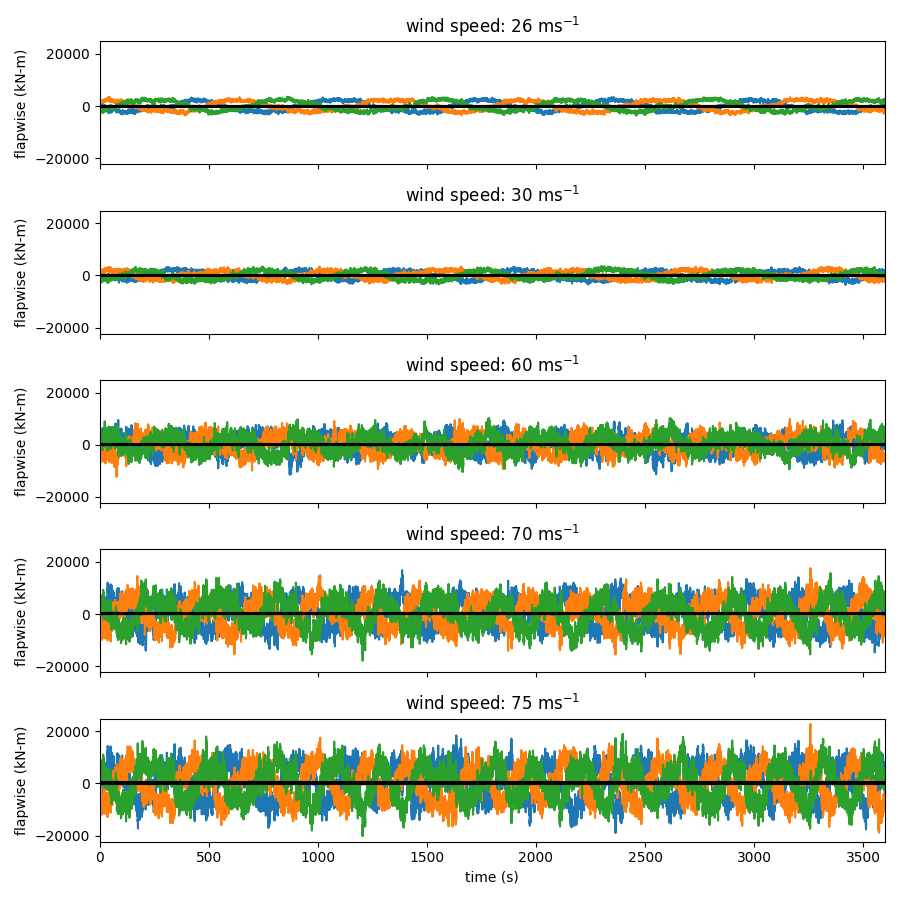

In [45]:
fig, ax = plt.subplots(figsize=(9,9),
                       nrows=len(timeseries.keys()),
                       sharex=True,
                       sharey=True
                      )
for i, ts in enumerate(sorted(timeseries)):
    flapwise_mean_blade_1 = timeseries[ts]['RootMFlp1 (kN-m)'].mean()
    flapwise_mean_blade_2 = timeseries[ts]['RootMFlp2 (kN-m)'].mean()
    flapwise_mean_blade_3 = timeseries[ts]['RootMFlp3 (kN-m)'].mean()
    
    ax[i].plot(timeseries[ts]['RootMFlp1 (kN-m)'])
    ax[i].plot(timeseries[ts]['RootMFlp2 (kN-m)'])
    ax[i].plot(timeseries[ts]['RootMFlp3 (kN-m)'])
    
    ax[i].axhline(y=flapwise_mean_blade_1, 
                  label='mean flapwise b1: {:1.2f}'.format(flapwise_mean_blade_1) + ' kN-m',
                  color='k'
                 )
    ax[i].axhline(y=flapwise_mean_blade_2, 
                  label='mean flapwise b2: {:1.2f}'.format(flapwise_mean_blade_2) + ' kN-m',
                  color='k'
                 )
    ax[i].axhline(y=flapwise_mean_blade_3, 
                  label='mean flapwise b3: {:1.2f}'.format(flapwise_mean_blade_3) + ' kN-m',
                  color='k'
                 )
    ax[i].set_ylabel('flapwise (kN-m)')
    #ax[i].legend(ncol=3, loc='upper center')
    ax[i].set_title('wind speed: {}'.format(ts) + ' ms$^{-1}$')
    ax[i].set_xlim([0, 3600])
    
ax[i].set_xlabel('time (s)')
fig.tight_layout()
fig.savefig('flapwise_timeseries.png', dpi=150)

All three flapwise moments show a very low frequency component where the magnitude of the moment is both symmetrical (~ -3 MNm to 3 MNm) and has an approximate phase shift of 120 DEG. 

Additionally all three moments depict higher frequency fluctuations

## FFT of flapwise moments as well as Rotor Speed and Wind Speed (mag)

<IPython.core.display.Javascript object>


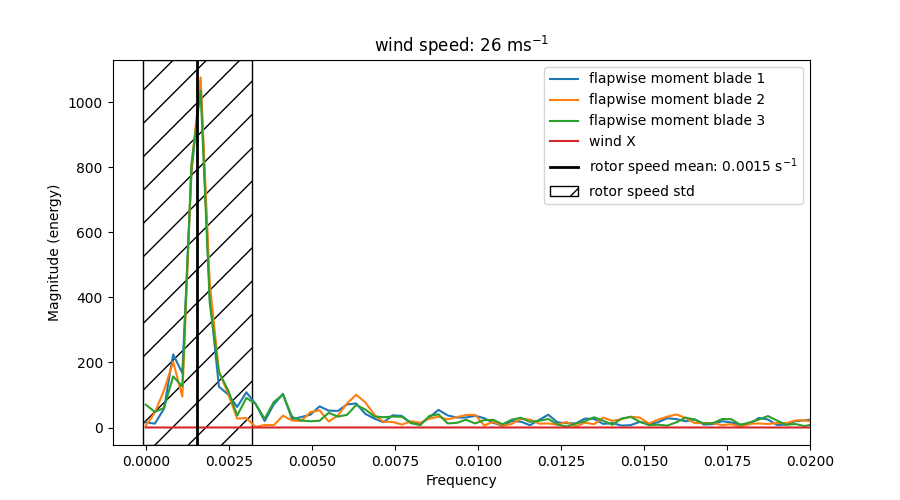

<IPython.core.display.Javascript object>


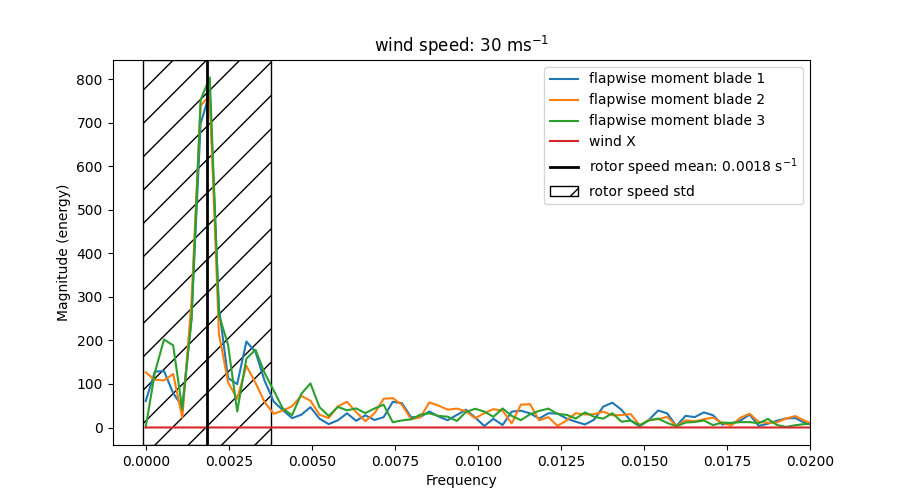

<IPython.core.display.Javascript object>


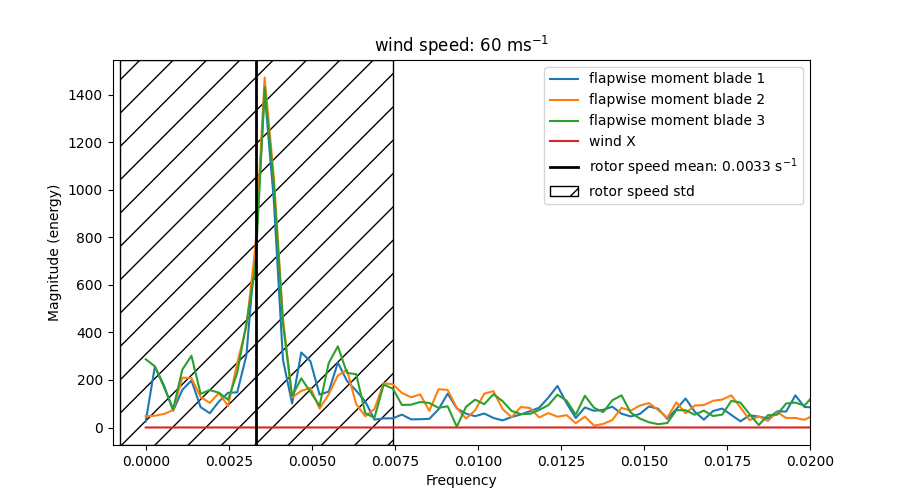

<IPython.core.display.Javascript object>


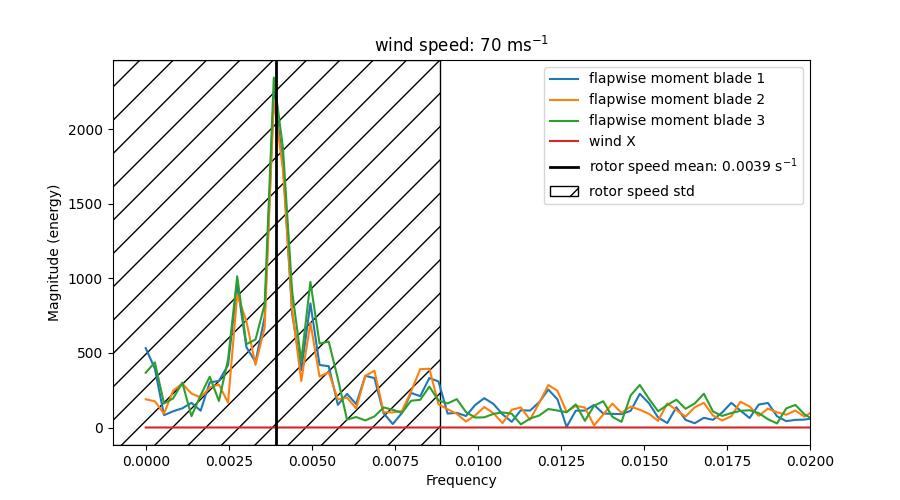

<IPython.core.display.Javascript object>


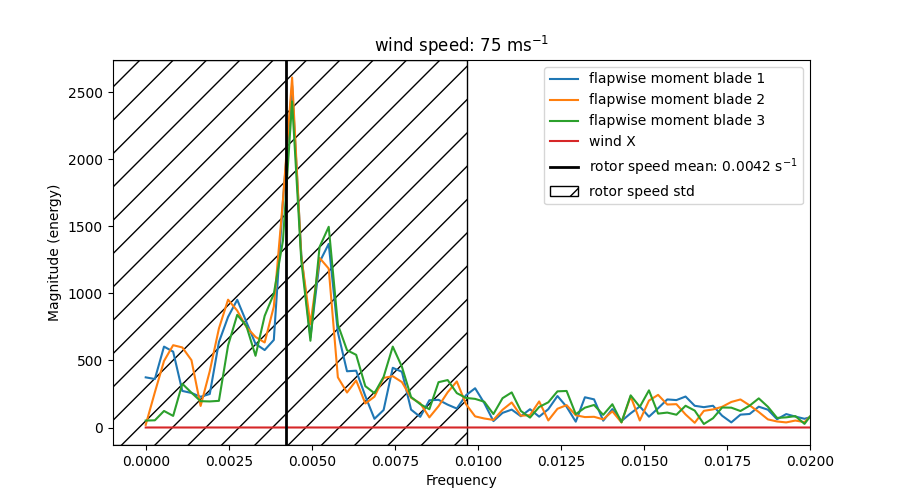

In [54]:
for ts in sorted(timeseries):
    deltaT = timeseries[ts].index[1] - timeseries[ts].index[0] # -> gives the deltaT needed to calculate the fourier frequencies
    Fs = 1/deltaT
    
    plt.figure(figsize=(9,5))

    # magnitude spectrum of the flapwise moments
    plt.magnitude_spectrum(timeseries[ts]['RootMFlp1 (kN-m)'], Fs=Fs, scale='linear', label='flapwise moment blade 1')
    plt.magnitude_spectrum(timeseries[ts]['RootMFlp2 (kN-m)'], Fs=Fs, scale='linear', label='flapwise moment blade 2')
    plt.magnitude_spectrum(timeseries[ts]['RootMFlp3 (kN-m)'], Fs=Fs, scale='linear', label='flapwise moment blade 3')

    # Wind1VelX   Wind1VelY   Wind1VelZ

    # magnitude spectrum of the wind in x direction
    plt.magnitude_spectrum(timeseries[ts]['Wind1VelZ (m/s)'] - timeseries[ts]['Wind1VelZ (m/s)'].mean(), Fs=Fs, scale='linear', label='wind X')

    # magnitude spectrum of rotor speed

    # plt.magnitude_spectrum(timeseries[ts]['RtSpeed (Hz)'] - timeseries[ts]['RtSpeed (Hz)'].mean(), Fs=Fs, scale='dB', label='Rotor speed')

    RtSpeedMean = abs(timeseries[ts]['RtSpeed (Hz)'].mean())
    RtSpeedStd = timeseries[ts]['RtSpeed (Hz)'].std()

    plt.axvline(x=RtSpeedMean, linewidth=2, label='rotor speed mean: {:1.4f}'.format(RtSpeedMean) + ' s$^{-1}$', color='k')
    plt.axvspan(xmin=RtSpeedMean - RtSpeedStd, 
                xmax=RtSpeedMean + RtSpeedStd, 
                hatch='/', 
                facecolor='white', 
                edgecolor='k',
                label='rotor speed std')

    plt.xlim([-0.001, 0.02])
    plt.legend()
    plt.title('wind speed: {}'.format(ts)+' ms$^{-1}$')
    plt.savefig('spectrum_detail_{}.png'.format(ts), dpi=150)

<IPython.core.display.Javascript object>


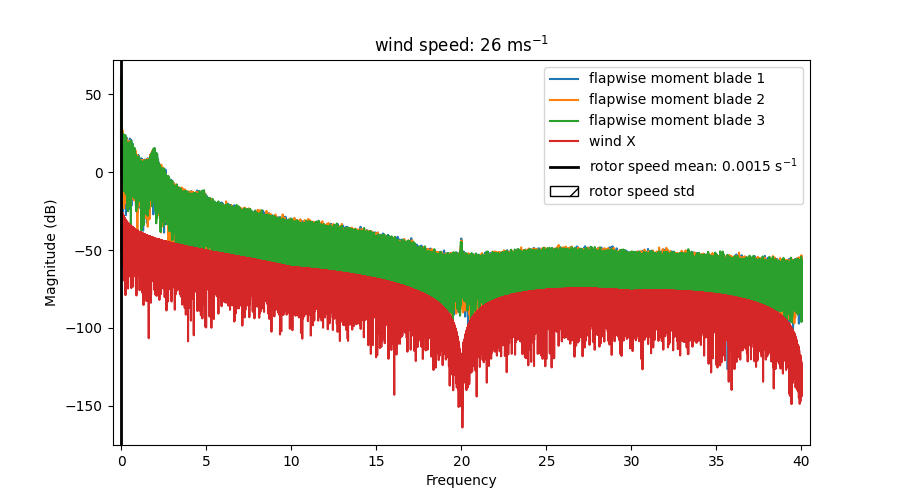

<IPython.core.display.Javascript object>


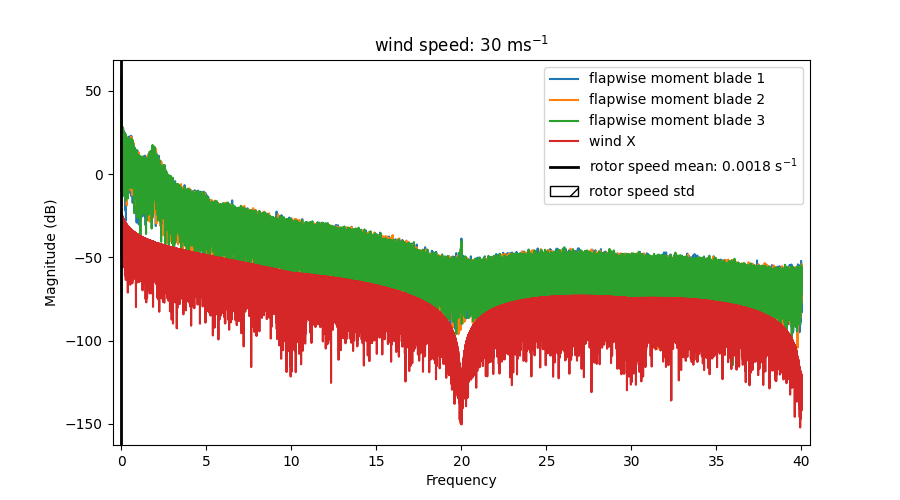

<IPython.core.display.Javascript object>


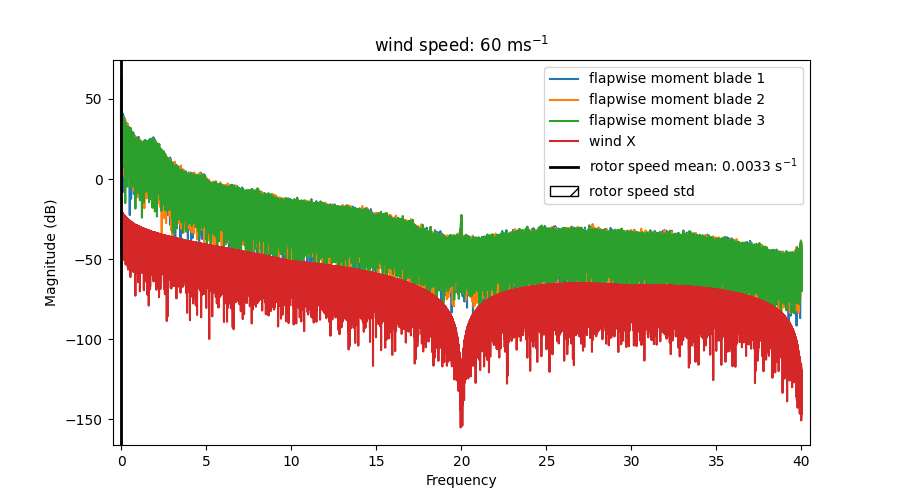

<IPython.core.display.Javascript object>


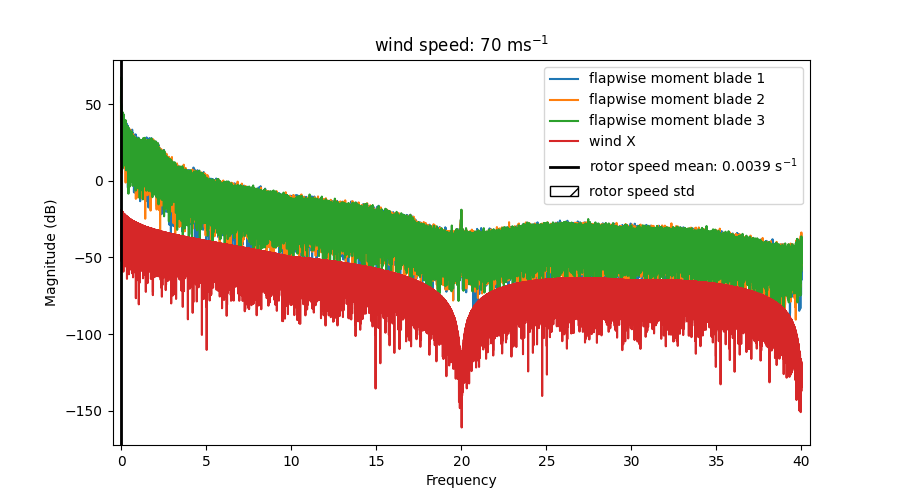

<IPython.core.display.Javascript object>


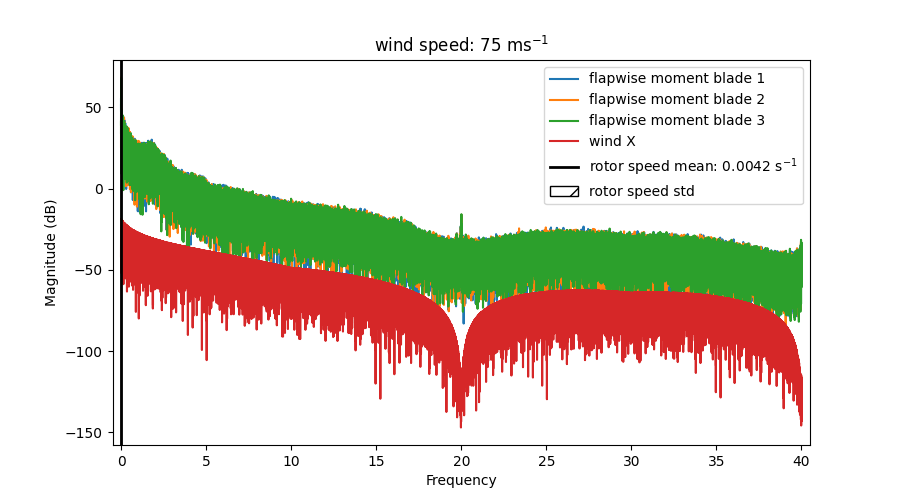

In [53]:
for ts in sorted(timeseries):
    deltaT = timeseries[ts].index[1] - timeseries[ts].index[0] # -> gives the deltaT needed to calculate the fourier frequencies
    Fs = 1/deltaT
    
    plt.figure(figsize=(9,5))

    # magnitude spectrum of the flapwise moments
    plt.magnitude_spectrum(timeseries[ts]['RootMFlp1 (kN-m)'], Fs=Fs, scale='dB', label='flapwise moment blade 1')
    plt.magnitude_spectrum(timeseries[ts]['RootMFlp2 (kN-m)'], Fs=Fs, scale='dB', label='flapwise moment blade 2')
    plt.magnitude_spectrum(timeseries[ts]['RootMFlp3 (kN-m)'], Fs=Fs, scale='dB', label='flapwise moment blade 3')

    # Wind1VelX   Wind1VelY   Wind1VelZ

    # magnitude spectrum of the wind in x direction
    plt.magnitude_spectrum(timeseries[ts]['Wind1VelZ (m/s)'] - timeseries[ts]['Wind1VelZ (m/s)'].mean(), Fs=Fs, scale='dB', label='wind X')

    # magnitude spectrum of rotor speed

    # plt.magnitude_spectrum(timeseries[ts]['RtSpeed (Hz)'] - timeseries[ts]['RtSpeed (Hz)'].mean(), Fs=Fs, scale='dB', label='Rotor speed')

    RtSpeedMean = abs(timeseries[ts]['RtSpeed (Hz)'].mean())
    RtSpeedStd = timeseries[ts]['RtSpeed (Hz)'].std()

    plt.axvline(x=RtSpeedMean, linewidth=2, label='rotor speed mean: {:1.4f}'.format(RtSpeedMean) + ' s$^{-1}$', color='k')
    plt.axvspan(xmin=RtSpeedMean - RtSpeedStd, 
                xmax=RtSpeedMean + RtSpeedStd, 
                hatch='/', 
                facecolor='white', 
                edgecolor='k',
                label='rotor speed std')

    plt.xlim([-0.5, 40.5])
    plt.legend()
    plt.title('wind speed: {}'.format(ts)+' ms$^{-1}$')
    plt.savefig('spectrum_overview_{}.png'.format(ts), dpi=150)